/=============================================\
| X-PSI: X-ray Pulse Simulation and Inference |
|---------------------------------------------|
|                Version: 2.0.0               |
|---------------------------------------------|
|      https://xpsi-group.github.io/xpsi      |
\=============================================/

Imported GetDist version: 1.4
Imported nestcheck version: 0.2.1
Rank reporting: 0
scenario is not in environment variables, using passed argument.
scenario: literature
machine variable is not in environment variables, using passed argument.
machine: local
run_type is not in environment variables, using passed argument.
run_type: test
cannot import analysis name, using test_analysis
analysis_name: test_analysis
num_energies from environment variables failed, proceeding with default.
num_energies: 40
num_leaves from environment variables failed, proceeding with default.
num_leaves: 30
sqrt_num_cells from environment variables failed, proceeding with default

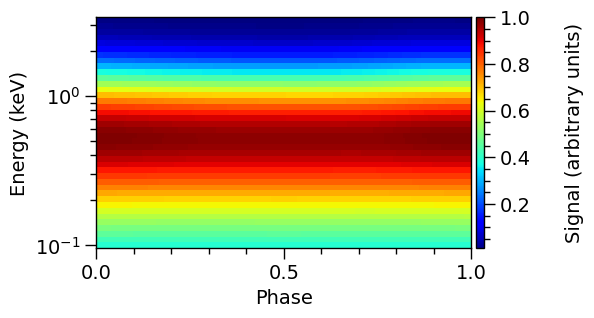

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Apr 11 10:48:58 2023

@author: bas, much copied from postprocessing tutorial
"""

# Importing relevant modules

# %matplotlib inline

# from __future__ import division

import sys
import os
import matplotlib.pyplot as plt

from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import MultipleLocator, AutoLocator, AutoMinorLocator
from matplotlib import gridspec
from matplotlib import cm
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import math

from collections import OrderedDict

import xpsi

from xpsi import PostProcessing

# choose a seed for the notebook if you want caching to be useful
# and the notebook exactly reproducible
PostProcessing.set_random_seed(42)

from xpsi.global_imports import gravradius


sys.path.append("../")
sys.path.append("../../")

from helper_functions import get_T_in_log10_Kelvin, get_keV_from_log10_Kelvin

from analysis import analysis
ST = analysis('local','test','fix', scenario='literature')
ST()


# We will use the same bounds used during sampling

# Settings names, bounds and labels

ST.names=['mass','radius','distance','cos_inclination','p__phase_shift','p__super_colatitude','p__super_radius','p__super_tbb','p__super_te','p__super_tau','elsewhere_temperature','T_in', 'R_in', 'column_density']

ST.bounds = {'mass':(1.0,3.0),
             'radius':(3.0 * gravradius(1.0), 16.0),
             'distance':(1., 5.),  # (2.5, 3.6), #(3.4, 3.6),
             'cos_inclination':(0.,1.),
             'p__phase_shift':(-0.25, 0.75),
             'p__super_colatitude':(0.001, math.pi - 0.001),
             'p__super_radius':(0.001, math.pi/2.0 - 0.001),
             'p__super_tbb':(0.001, 0.003),
             'p__super_te': (40., 200.),
             'p__super_tau': (0.5, 3.5),
             'elsewhere_temperature': (5., 7.), #(6.5, 7.),
             'T_in': (5.065e+00, 6.843e+00),
             'R_in': (20., 64.),
             'column_density': (0., 3.)}


# Now the labels
ST.labels = {'mass': r"M\;\mathrm{[M}_{\odot}\mathrm{]}",
              'radius': r"R_{\mathrm{eq}}\;\mathrm{[km]}",
              'distance': r"D \;\mathrm{[kpc]}",
              'cos_inclination': r"\cos(i)",
              'p__phase_shift': r"\phi_{p}\;\mathrm{[cycles]}",
              'p__super_colatitude': r"\Theta_{spot}\;\mathrm{[rad]}",
              'p__super_radius': r"\zeta_{spot}\;\mathrm{[rad]}",
              'p__super_tbb': r"t_{bb}\;\mathrm{[data units]}",
              'p__super_te': r"t_e data units",
              'p__super_tau': "tau unitless",
              'elsewhere_temperature': r"T_e log10 of Kelvin",
              'T_in': r"T_{in} log10 of Kelvin",
              'R_in': r"R_{in} km",
              'column_density': r"n_H 10\^21 cm\^{-2}"}


ST.truths={'mass': 1.4,                               # Mass in solar Mass
          'radius': 11.,                              # Equatorial radius in km
          'distance': 3.5,                            # Distance in kpc
          'cos_inclination': math.cos(math.pi*58/180),          # Cosine of Earth inclination to rotation axis
          'p__phase_shift': 0.2,                    # Phase shift
          'p__super_colatitude': 11*math.pi/180,                # Colatitude of the centre of the superseding region
          'p__super_radius': 10*math.pi/180,                 # Angular radius of the (circular) superseding region
          'p__super_tbb': 0.85/511,                      # Blackbody temperature
          'p__super_te': 50*1000/511.,                          # Electron temperature
          'p__super_tau': 1.,
          'elsewhere_temperature': get_T_in_log10_Kelvin(0.5),
          'T_in': get_T_in_log10_Kelvin(0.29),
          'R_in': 55.,
          'column_density': 1.13}


#### add parameters

ST.names +=['compactness']
ST.bounds['compactness']=(0.0, 10.)#(gravradius(1.0)/16.0, 1.0/3.0)
ST.labels['compactness']= r"M/R_{\mathrm{eq}}"
ST.truths['compactness']=gravradius(ST.truths['mass'])/ST.truths['radius']

ST.names +=['T_else_keV']
ST.bounds['T_else_keV']=(None, None)#(gravradius(1.0)/16.0, 1.0/3.0)
ST.labels['T_else_keV']= r"T_{\mathrm{else}} (keV)"
ST.truths['T_else_keV'] = get_keV_from_log10_Kelvin(ST.truths['elsewhere_temperature'])

ST.names +=['T_in_keV']
ST.bounds['T_in_keV']=(None, None)
ST.labels['T_in_keV']= r"T_{\mathrm{in}} (keV)"
ST.truths['T_in_keV'] = get_keV_from_log10_Kelvin(ST.truths['T_in'])

ST.names +=['tbb_keV']
ST.bounds['tbb_keV']=(None, None)
ST.labels['tbb_keV']= r"T_{bb} (keV)"
ST.truths['tbb_keV'] = ST.truths['p__super_tbb']*511

ST.names +=['te_keV']
ST.bounds['te_keV']=(None, None)
ST.labels['te_keV']= r"T_{e} (keV)"
ST.truths['te_keV'] = ST.truths['p__super_te']*511/1000


getdist_kde_settings = {'ignore_rows': 0,
                        'min_weight_ratio': 1.0e-10,
                        'contours': [0.683, 0.954, 0.997],
                        'credible_interval_threshold': 0.001,
                        'range_ND_contour': 0,
                        'range_confidence': 0.001,
                        'fine_bins': 1024,
                        'smooth_scale_1D': 0.4,
                        'num_bins': 100,
                        'boundary_correction_order': 1,
                        'mult_bias_correction_order': 1,
                        'smooth_scale_2D': 0.4,
                        'max_corr_2D': 0.99,
                        'fine_bins_2D': 512,
                        'num_bins_2D': 40}

print('names',ST.names)
print('likelihood:', ST.likelihood)



In [2]:
base_dir='/home/bas/Documents/Projects/x-psi/xpsi-bas-fork/AMXPs/J1808_synthetic/snellius_runs'

# To compare poisson vs no poisson, remake synthetic data. with correct customsignal.

# job_id = 4977822
# job_label = 'np_sfac_1.1_lp192'

job_id = 5019340
job_label = 'no_bg_no_sp_lp192'


ST.runs = xpsi.Runs.load_runs(ID='ST',
                               run_IDs=job_label,
                               roots=['run_ST_'],
                               base_dirs=f'{base_dir}/{job_label}/{job_id}/{job_label}',
                               use_nestcheck=[False],
                               kde_settings=getdist_kde_settings,
                               likelihood=ST.likelihood,
                               names=ST.names,
                               bounds=ST.bounds,
                               labels=ST.labels,
                               truths=ST.truths,
                               implementation='multinest',
                               overwrite_transformed=True)


pp = xpsi.PostProcessing.CornerPlotter([ST.runs])
fig = pp.plot(
     params=ST.names,
     IDs=OrderedDict([('ST', job_labels),]),
     prior_density=False,
     KL_divergence=True,
     ndraws=5e4,
     combine=False, combine_all=True, only_combined=False, overwrite_combined=True,
     param_plot_lims={},
     bootstrap_estimators=False,
     bootstrap_density=False,
     n_simulate=200,
     crosshairs=True,
     write=True,
     ext='.png',
     maxdots=3000,
     root_filename=f'run',
     credible_interval_1d=True,
     #credible_interval_1d_all_show=True, # To show credible intervals for all runs/models
     #show_vband=[0,1],                   # To list which vertical colored bands are shown in 1D-posteriors
     #                                    #  0 for run_seed0,  1 for run_seed42
     annotate_credible_interval=True,
     compute_all_intervals=False,
     sixtyeight=True,
     axis_tick_x_rotation=45.0,
     num_plot_contours=3,
     subplot_size=4.0,
     legend_corner_coords=(0.675,0.8),
     legend_frameon=False,
     scale_attrs=OrderedDict([('legend_fontsize', 2.0),
                              ('axes_labelsize', 1.35),
                              ('axes_fontsize', 'axes_labelsize'),
                             ]
                            ),
     colormap='Reds',
     shaded=True,
     shade_root_index=-1,
     rasterized_shade=True,
     no_ylabel=True,
     no_ytick=True,
     lw=1.0,
     lw_1d=1.0,
     filled=False,
     normalize=True,
     veneer=True,
     #contour_colors=['orange'],
     tqdm_kwargs={'disable': False},
     lengthen=2.0,
     embolden=1.0,
     nx=500)


f'{base_dir}/{job_label}/{job_id}/{job_label}'

In [3]:
roots = []
job_ids = []
job_labels = []
run_ids = []

# negative background allowed, no support
# job_ids.append('5204648')
# job_labels.append('neg_bkg_lp192')

# fixed background
job_ids.append('5133792')
job_labels.append('given_bg_lp192')
run_ids.append('bkg_fixed')

# no support
# job_ids.append('4960988')
# job_labels.append('no_poisson_lp192')

# sf = 1.5, seed = 7
# job_ids.append('5210494')
# job_labels.append('sf_15_lp192')

# sf = 1.1, seed = 7
# job_ids.append('4977822')
# job_labels.append('np_sfac_1.1_lp192')
# job_ids.append('5216186')
# job_labels.append('sf_11_se_7_lp192')

# sf = 1.1, seed = 0
# job_ids.append('5210560')
# job_labels.append('sf_11_se_0_lp192')

# sf = 1.1, seed = 1
# job_ids.append('5210597')
# job_labels.append('sf_11_se_1_lp192')

# sf = 1.1, seed = 7, lp = 1000
# job_ids.append('5210748')
# job_labels.append('sf_11_lp1000')

# sf = 1.1, seed = 7, poisson noise
# job_ids.append('5215731')
# job_labels.append('sf_11_pn_lp192')

# sf = 1.001
# job_ids.append('5134108')
# job_labels.append('sf_1001_lp192')
# run_ids.append('old')

# sf = 1.001 (2) 
# job_ids.append('5217380')
# job_labels.append('sf_1001_lp192')
# run_ids.append('new')

# sf = 1.001 negative background allowed, 
# job_ids.append('5206416')
# job_labels.append('nb_sf_1001_lp192')

# sf = 1.00005
# job_ids.append('5196881')
# job_labels.append('sf_100005_lp192')

# bkg_derived_lp192  
# job_ids.append('5316365')
# job_labels.append('bkg_derived_lp192')
# run_ids.append('bkg_derived')

# bkg_tight_lp192
# job_ids.append('5325163')
# job_labels.append('bkg_tight_lp192')
# run_ids.append('bkg_tight')

# realdata_lp192
# job_ids.append('5385333')
# job_labels.append('realdata_lp192')
# run_ids.append('realdata')

# realdata_lp1000
# job_ids.append('5390610')
# job_labels.append('realdata_lp1000')
# run_ids.append('lp1000')

# realdata_lp1000_multi
# job_ids.append('5413794')
# job_labels.append('realmulti_lp1000')
# run_ids.append('lp1000_multi')

# reallowdlim_lp192
# job_ids.append('5413815')
# job_labels.append('reallowdlim_lp192')
# run_ids.append('reallowdlim_lp192')


# realdata_2022
# job_ids.append('5415651')
# job_labels.append('2022lowd_lp192')
# run_ids.append('2022 lowd')

# job_ids.append('5415668')
# job_labels.append('2022highd_lp192')
# run_ids.append('2022 highd')


#new distance
# job_ids.append('5442357')
# job_labels.append('2019newd_lp1000')
# run_ids.append('2019 newd')

# job_ids.append('5442163')
# job_labels.append('2022newd_lp1000')
# run_ids.append('2022 newd')

# kajava 
# job_ids.append('5523257')
# job_labels.append('k_sf_none_lp192')
# run_ids.append('sf_none')

# job_ids.append('5523560')
# job_labels.append('k_sf_5e-1_lp192')
# run_ids.append('sf_5e-1')

# job_ids.append('incomplete')
# job_labels.append('k_bkg_tight_lp192')
# run_ids.append('k_bkg_tight')


base_dirs = []
for job_id, job_label, index in zip(job_ids, job_labels, range(len(job_ids))):
    base_dirs.append(f'{base_dir}/{job_label}/{job_id}/{job_label}')
    roots.append('run_ST_')

In [4]:
ST.runs = xpsi.Runs.load_runs(ID='ST',
                               run_IDs=run_ids,
                               roots=roots,
                               base_dirs=base_dirs,
                               use_nestcheck=[False]*len(job_ids),
                               kde_settings=getdist_kde_settings,
                               likelihood=ST.likelihood,
                               names=ST.names,
                               bounds=ST.bounds,
                               labels=ST.labels,
                               truths=ST.truths,
                               implementation='multinest',
                               overwrite_transformed=True)

IndexError: index 13 is out of bounds for axis 0 with size 12

In [ ]:
def cornerplot(parameters): 
    pp = xpsi.PostProcessing.CornerPlotter([ST.runs])
    fig = pp.plot(
         params=parameters,
         IDs=OrderedDict([('ST', run_ids),]),
         prior_density=False,
         KL_divergence=True,
         ndraws=5e4,
         combine=False, combine_all=True, only_combined=False, overwrite_combined=True,
         param_plot_lims={},
         bootstrap_estimators=False,
         bootstrap_density=False,
         n_simulate=200,
         crosshairs=True,
         write=True,
         ext='.png',
         maxdots=3000,
         root_filename=f'run',
         credible_interval_1d=True,
         credible_interval_1d_all_show=True, # To show credible intervals for all runs/models
         show_vband=[0,1],                   # To list which vertical colored bands are shown in 1D-posteriors
                                             #  0 for run_seed0,  1 for run_seed42
         annotate_credible_interval=True,
         compute_all_intervals=False,
         sixtyeight=True,
         axis_tick_x_rotation=45.0,
         num_plot_contours=3,
         subplot_size=4.0,
         legend_corner_coords=(0.675,0.8),
         legend_frameon=False,
         scale_attrs=OrderedDict([('legend_fontsize', 2.0),
                                  ('axes_labelsize', 1.35),
                                  ('axes_fontsize', 'axes_labelsize'),
                                 ]
                                ),
         colormap='Reds',
         shaded=True,
         shade_root_index=-1,
         rasterized_shade=True,
         no_ylabel=True,
         no_ytick=True,
         lw=1.0,
         lw_1d=1.0,
         filled=False,
         normalize=True,
         veneer=True,
         #contour_colors=['orange'],
         tqdm_kwargs={'disable': False},
         lengthen=2.0,
         embolden=1.0,
         nx=500)


In [ ]:
mass_radius = ["mass", "radius", "compactness"]
cornerplot(mass_radius)

In [ ]:
interstellar = ["distance", "column_density"]
cornerplot(interstellar)


In [ ]:
geometry = ['cos_inclination', 'p__phase_shift', 'p__super_colatitude', 'p__super_radius']

cornerplot(geometry)

In [ ]:
atmosphere = ['tbb_keV', 'te_keV', 'p__super_tau']
cornerplot(atmosphere)

In [ ]:
background = ['T_else_keV', 'T_in_keV', 'R_in']

cornerplot(background)

In [ ]:
pp = xpsi.SignalPlotter([ST.runs])
pp.plot(IDs=OrderedDict([('ST', run_ids),
                        ]),
        combine=False, # use these controls if more than one run for a posterior
        combine_all=False,
        force_combine=False,
        only_combined=False,
        force_cache=True,
        nsamples=3,
        plots = {'ST': xpsi.ResidualPlot()})

pp.plots["ST"].fig


#%%

# plt.savefig(f'./corner_run_se={sampling_efficiency}_lp={live_points}_atm={atmosphere_type}{n_params}_ne={num_energies}_mi={max_iterations}.png')



pp = xpsi.PostProcessing.CornerPlotter([ST.runs])
fig = pp.plot(
     params=["mass", "radius", "compactness"],
     IDs=OrderedDict([('ST', job_labels),]),
     prior_density=False,
     KL_divergence=True,
     ndraws=5e4,
     combine=False, combine_all=True, only_combined=False, overwrite_combined=True,
     param_plot_lims={},
     bootstrap_estimators=False,
     bootstrap_density=False,
     n_simulate=200,
     crosshairs=True,
     write=True,
     ext='.png',
     maxdots=3000,
     root_filename=f'run',
     credible_interval_1d=True,
     credible_interval_1d_all_show=True, # To show credible intervals for all runs/models
     show_vband=[0,1],                   # To list which vertical colored bands are shown in 1D-posteriors
                                         #  0 for run_seed0,  1 for run_seed42
     annotate_credible_interval=True,
     compute_all_intervals=False,
     sixtyeight=True,
     axis_tick_x_rotation=45.0,
     num_plot_contours=3,
     subplot_size=4.0,
     legend_corner_coords=(0.675,0.8),
     legend_frameon=False,
     scale_attrs=OrderedDict([('legend_fontsize', 2.0),
                              ('axes_labelsize', 1.35),
                              ('axes_fontsize', 'axes_labelsize'),
                             ]
                            ),
     colormap='Reds',
     shaded=True,
     shade_root_index=-1,
     rasterized_shade=True,
     no_ylabel=True,
     no_ytick=True,
     lw=1.0,
     lw_1d=1.0,
     filled=False,
     normalize=True,
     veneer=True,
     #contour_colors=['orange'],
     tqdm_kwargs={'disable': False},
     lengthen=2.0,
     embolden=1.0,
     nx=500)



In [ ]:
# pp = xpsi.PostProcessing.CornerPlotter([ST.runs])
# fig = pp.plot(
#      params=ST.names,
#      IDs=OrderedDict([('ST', run_ids),]),
#      prior_density=False,
#      KL_divergence=True,
#      ndraws=5e4,
#      combine=False, combine_all=True, only_combined=False, overwrite_combined=True,
#      param_plot_lims={},
#      bootstrap_estimators=False,
#      bootstrap_density=False,
#      n_simulate=200,
#      crosshairs=True,
#      write=True,
#      ext='.png',
#      maxdots=3000,
#      root_filename=f'run',
#      credible_interval_1d=True,
#      credible_interval_1d_all_show=True, # To show credible intervals for all runs/models
#      show_vband=[0,1],                   # To list which vertical colored bands are shown in 1D-posteriors
#                                          #  0 for run_seed0,  1 for run_seed42
#      annotate_credible_interval=True,
#      compute_all_intervals=False,
#      sixtyeight=True,
#      axis_tick_x_rotation=45.0,
#      num_plot_contours=3,
#      subplot_size=4.0,
#      legend_corner_coords=(0.675,0.8),
#      legend_frameon=False,
#      scale_attrs=OrderedDict([('legend_fontsize', 2.0),
#                               ('axes_labelsize', 1.35),
#                               ('axes_fontsize', 'axes_labelsize'),
#                              ]
#                             ),
#      colormap='Reds',
#      shaded=True,
#      shade_root_index=-1,
#      rasterized_shade=True,
#      no_ylabel=True,
#      no_ytick=True,
#      lw=1.0,
#      lw_1d=1.0,
#      filled=False,
#      normalize=True,
#      veneer=True,
#      #contour_colors=['orange'],
#      tqdm_kwargs={'disable': False},
#      lengthen=2.0,
#      embolden=1.0,
#      nx=500)

![Kajava spectra](kajavaspectra.png)

In [ ]:

#incomplete kajava tight bkg run
p_maxl = [0.170507728540301917E+01,
          0.952025661057614769E+01,
          0.353393091912659330E+01,
          0.534070033227823537E+00,
          0.183982640380558671E+00,
          0.247517540472243641E+00,
          0.182612005648162073E+00,
          0.197886208686230431E-02,
          0.178685675071135108E+03,
          0.106503701760243707E+01,
          0.682601745610152744E+01,
          0.652828425763148790E+01,
          0.550721729539257510E+02,
          0.112921975109461648E+01]

ST.likelihood(p_maxl, reinitialise=True)
plt.plot(np.sum(ST.background.registered_background*ST.data.exposure_time, axis=1))
bg_spectrum = np.loadtxt(ST.file_bkg)
plt.plot(bg_spectrum*ST.data.exposure_time)